# Measure asymmetry and CAS of HSC imaging data

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight == 0.2.1

For more information, please contact me: dingxuheng@126.com or dingxh@whu.edu.cn

This notebook is to demonstrate the measurement of the non-parameteric values for galaxy morphology study.
The used target is a HSC QSO, in this notebook, the example starts with measuring asymmetry of the original image (without any sersic fitting). Then, perform sersic fitting to remove the PS and measure the host's asymmetry value. And then, measuring the asymmetry of the residual image. Finally, the measurement of CAS value are also performed for original image, host image and residual image.

## Load the data and get prepared use data_process:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...


Deblending: 100%|████████████████████████████████| 3/3 [00:00<00:00, 442.73it/s]


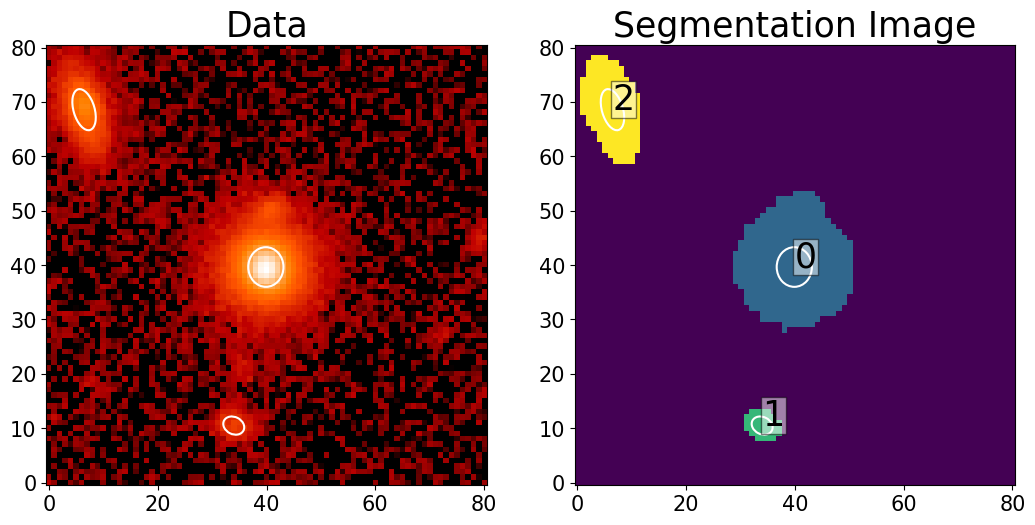

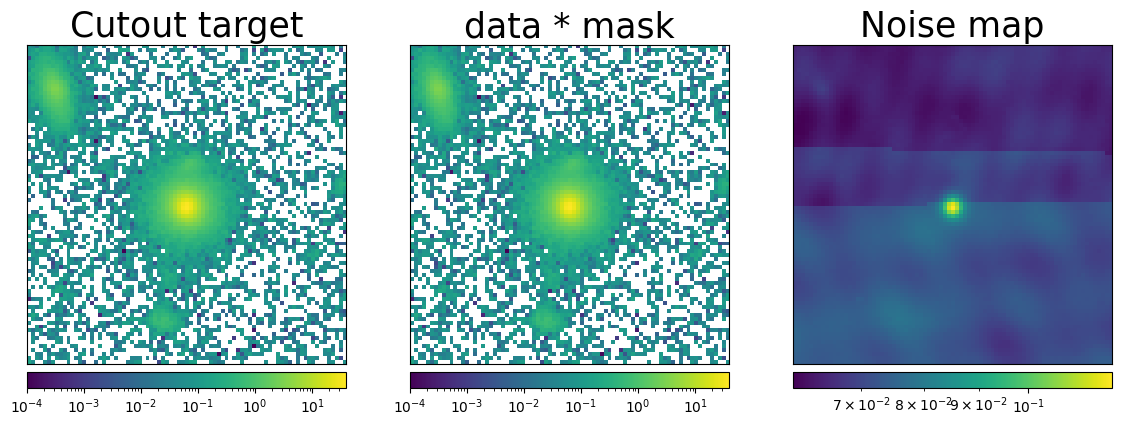

The PSF is not a box size, will cut it to a box size automatically.
The negative PSF values are corrected as 0 values.
The data_process is ready to go to pass to FittingSpecify!


In [2]:
from galight.data_process import DataProcess
#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=None, create_mask = False, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Input the PSF information.
data_process.PSF_list = [PSF]

#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

## (Optional:) One can manually modify the aperture and segm for a specific asy measure task using following box:
### You can active this box you need this function. 

In [3]:
# #Update the apretures:
# import copy
# apertures = copy.deepcopy(data_process.apertures)
# add_aperture0 = copy.deepcopy(apertures[0])
# add_aperture0.a, add_aperture0.b = 3, 3 # A a b for aperture
# add_aperture0.positions = np.array([40,50])
# data_process.apertures = apertures +  [add_aperture0]#Pass apertures to the data_process

# #Update the segm map:
# from galight.tools.measure_tools import mask_obj
# mask = mask_obj(data_process.target_stamp, [add_aperture0])
# data_process.segm_deblend = data_process.segm_deblend*mask[0] + (1-mask[0])*(np.max(data_process.segm_deblend)+1)
# plt.imshow(data_process.segm_deblend, origin='lower')
# plt.colorbar()
# plt.show()

## Asy -- Part 1:
### Let's try to direct measure the Asymmetry value without doing any Sersic fitting. You can direct setting up the fit_sepc and fit_run without performing the Sersic fitting.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


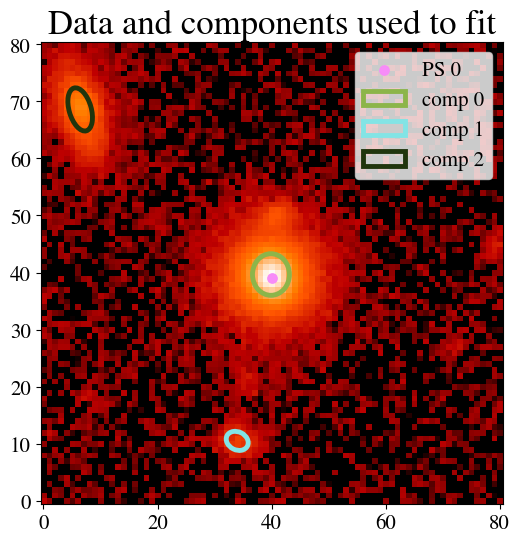

In [4]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook galight_HST_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

from galight.fitting_process import FittingProcess
fit_run = FittingProcess(fit_sepc)

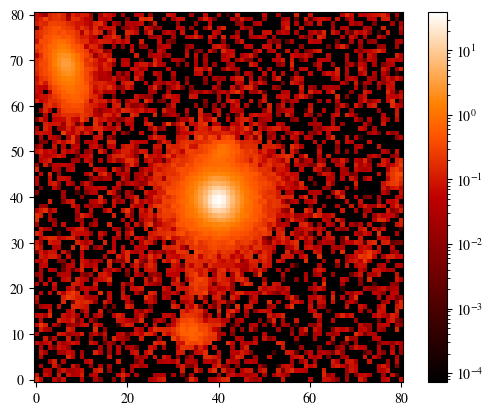

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 86.502090
         Iterations: 81
         Function evaluations: 161
The pixel position that gives you the minimized asy: [-0.1293708 -0.6545808]


Deblending: 100%|██████████████████████████████| 10/10 [00:00<00:00, 621.12it/s]


Plot the minimized abs residual:


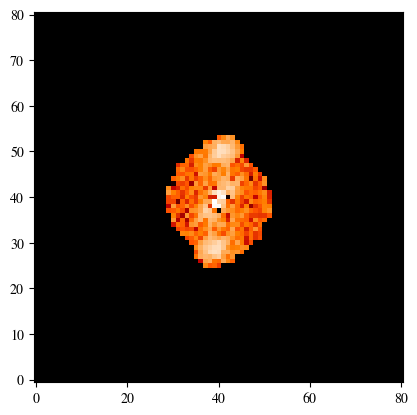

Plot the region to estiamte the background asymmetry:


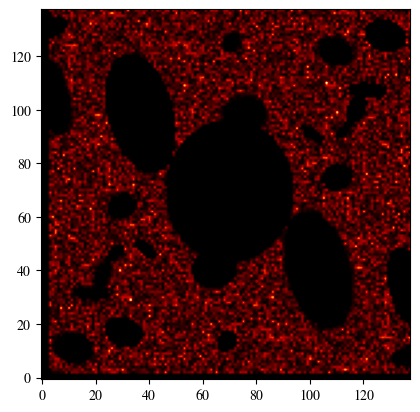

asymmetry : 0.052723279093063645


In [5]:
from galight.tools.asymmetry_tools import Measure_asy
from galight.tools.astro_tools import plt_fits
import pickle

#If setting as true, galight will expand the cutout to collect background pixels so that it have 25 times larger region than the target segm region.
#Note that, to allow this, you need to have the data_process in the fit_run (i.e., fit_run.fitting_specify_class.data_process_class)
if_remeasure_bkg = True

asy_class = Measure_asy(fit_run, seg_cal_reg = 'or', obj_id=0)  #The obj_id is the comp_id you see in figure above.

#Plot the image data:
plt_fits(asy_class.img,colorbar=True)

#Following is to define the mask type to clarify the pixels to measure. 
asy_class.asy_segm(mask_type='segm')  #Try also mask_type='aper'; you can feed you own segm if you have one.

#Using find_pos() to minimize the pos that gives you the lowest asy values. 
pos = asy_class.find_pos()
print('The pixel position that gives you the minimized asy:', pos["x"])

#Cal asy value and plot.
asy_class.make_bkg(rotate_pix = pos["x"], if_remeasure_bkg=if_remeasure_bkg)
asy = asy_class.cal_asymmetry(rotate_pix = pos["x"], if_plot=True, if_plot_bkg=True)
print('asymmetry :', asy)

### (Optional) In the following two box, Asymmetry is measured based on the petrosian radius. 

Measuring the position for minimized asy...


/Users/Dartoon/Astro/my_packages/galight/galight/tools/measure_tools.py:301: RuntimeWarning: invalid value encountered in divide
  r_SB[1:] = (r_flux[1:]-r_flux[:-1]) / (region_size[1:]-region_size[:-1])


Optimization terminated successfully.
         Current function value: 72.893616
         Iterations: 81
         Function evaluations: 167
The pixel position that gives you the minimized asy: [-0.12936692 -0.65458063]


Deblending: 100%|████████████████████████████████| 8/8 [00:00<00:00, 595.56it/s]
/Users/Dartoon/Astro/my_packages/galight/galight/tools/measure_tools.py:301: RuntimeWarning: invalid value encountered in divide
  r_SB[1:] = (r_flux[1:]-r_flux[:-1]) / (region_size[1:]-region_size[:-1])


Plot the minimized abs residual:


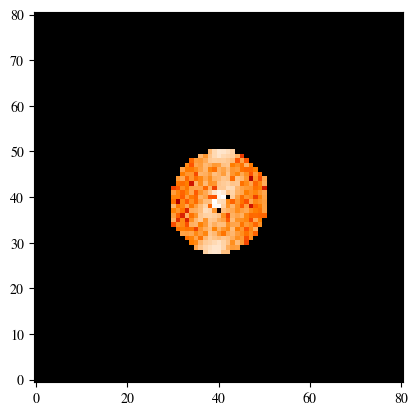

Plot the region to estiamte the background asymmetry:


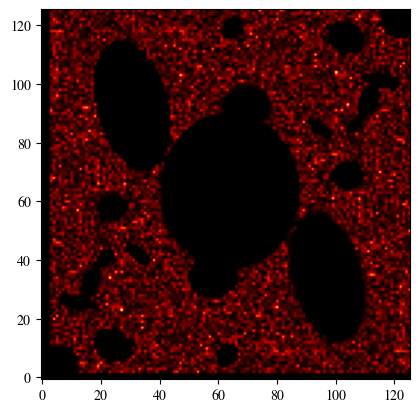

asymmetry : 0.04633252656049724


In [6]:
obj_id=0

#Use petrosian raidus to measure asy by setting consider_petrosian=True:
if_remeasure_bkg = True
asy_class = Measure_asy(fit_run, seg_cal_reg = 'or', obj_id=obj_id,
                        consider_petrosian=True, 
                        eta=0.2) 

#Following is to define the mask type to clarify the pixels to measure. 
asy_class.asy_segm(mask_type='segm',extend=1.5)  #Try also mask_type='aper'; you can feed you own segm if you have one.

#Using find_pos() to minimize the pos that gives you the lowest asy values. 
pos = asy_class.find_pos()
print('The pixel position that gives you the minimized asy:', pos["x"])

#Cal asy value and plot.
asy_class.make_bkg(rotate_pix = pos["x"], if_remeasure_bkg=if_remeasure_bkg)
asy = asy_class.cal_asymmetry(rotate_pix = pos["x"],
                              if_plot=True, if_plot_bkg=True)
print('asymmetry :', asy)

### For petrosian radius --- You can also directly measure the petrosian radius and compute the pixel counts in a ellips petrosian radius:

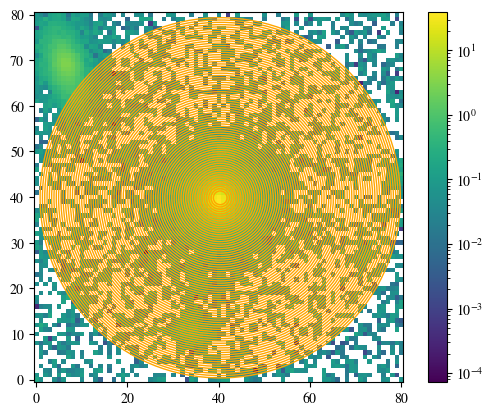

Plot the measure of petrosian radius:


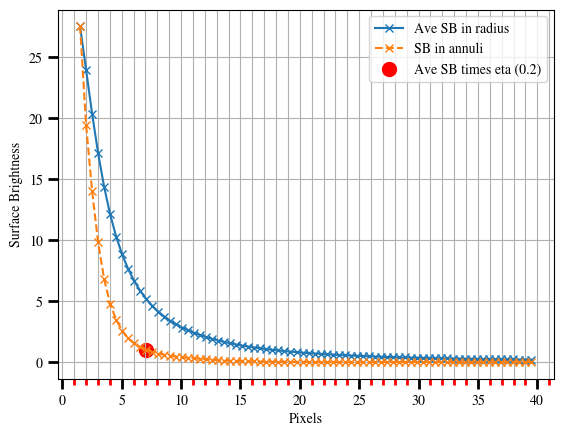

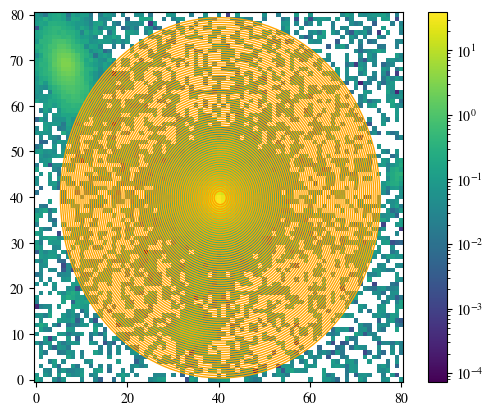

Plot the measure of petrosian radius:


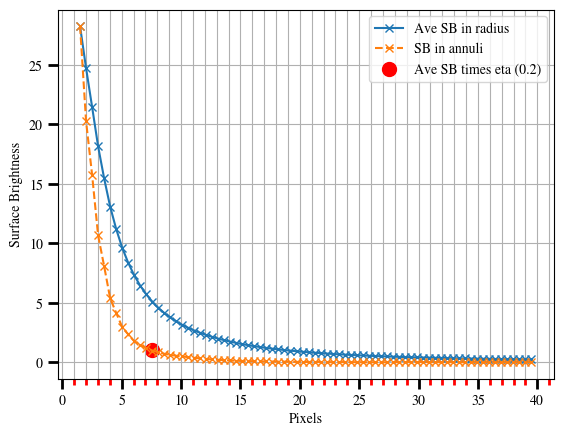

7.0687500000000005 7.574999999999999


/var/folders/9p/0fr680h559989srj06m13z780000gn/T/ipykernel_44839/1977663170.py:16: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture


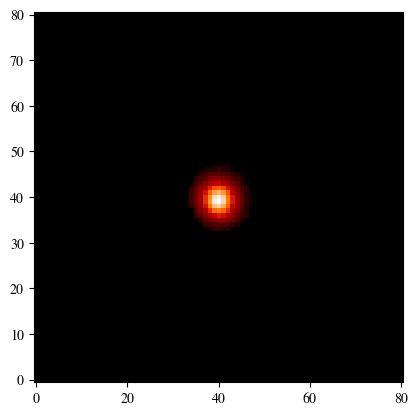

In [7]:
from galight.tools.asymmetry_tools import cal_r_petrosian
#Measure petrosian radius (given a center of radius.)
#Use circular aperture.
# you also also input a mask by setting mask=a_2d_array .
r_p_c = cal_r_petrosian(asy_class.img, #mask=a_2d_array,
                      center = pos['x']+np.array([len(asy_class.img)/2]*2),
                      if_plot=True)
#Use ellipse aperture.
r_p_e = cal_r_petrosian(asy_class.img,
                      center = pos['x']+np.array([len(asy_class.img)/2]*2),
                      q = data_process.apertures[obj_id].b/data_process.apertures[obj_id].a,
                      theta = data_process.apertures[obj_id].theta,
                      if_plot=True)
print(r_p_c, r_p_e)

from photutils import EllipticalAperture
q = data_process.apertures[obj_id].b/data_process.apertures[obj_id].a
ap = EllipticalAperture(pos['x']+np.array([len(asy_class.img)/2]*2), 
                        a = r_p_e, 
                        b = r_p_e * q,
                        theta=data_process.apertures[obj_id].theta)

from galight.tools.measure_tools import mask_obj
mask_ap = mask_obj(asy_class.img, [ap])[0]  #The mask for the ellips aperture
#data = mask.cutout(asy_class.img)
#plt.imshow(mask.data*data)
#print(np.sum(mask.data*data))
from galight.tools.astro_tools import plt_fits
counts_in_aperture = (1-mask_ap)*asy_class.img
plt_fits(counts_in_aperture)

## Asy - Part 2:
### Let's perform the Sersic+AGN fitting so that we can remove the point source to measure the host Asy values. 

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.4817508583558292 reduced X^2 of best position
-4843.102680536028 log likelihood
6537.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9520728913831182, 'n_sersic': 1.5008151534555243, 'e1': -0.06837851243967433, 'e2': 0.05702711578647715, 'center_x': 0.07057299597760235, 'center_y': -0.062021540904647336}, {'amp': 1, 'R_sersic': 0.22344132600444952, 'n_sersic': 0.7251936928240716, 'e1': -0.1301328091248402, 'e2': 0.23400656623986676, 'center_x': 0.8997658021425103, 'center_y': -5.018497124229626}, {'amp': 1, 'R_sersic': 0.8920360695515346, 'n_sersic': 4.22408204106886, 'e1': -0.486527048201849, 'e2': 0.26811674234072586, 'center_x': 5.629950849231648, 'center_y': 4.867205897637733}] lens light result
[{'ra_image': array([0.0219817]), 'dec_image': array([-0.1158522]), 'point_amp': array([1.])}] point source result
[] tracer source result
{} special param result
5.708940982

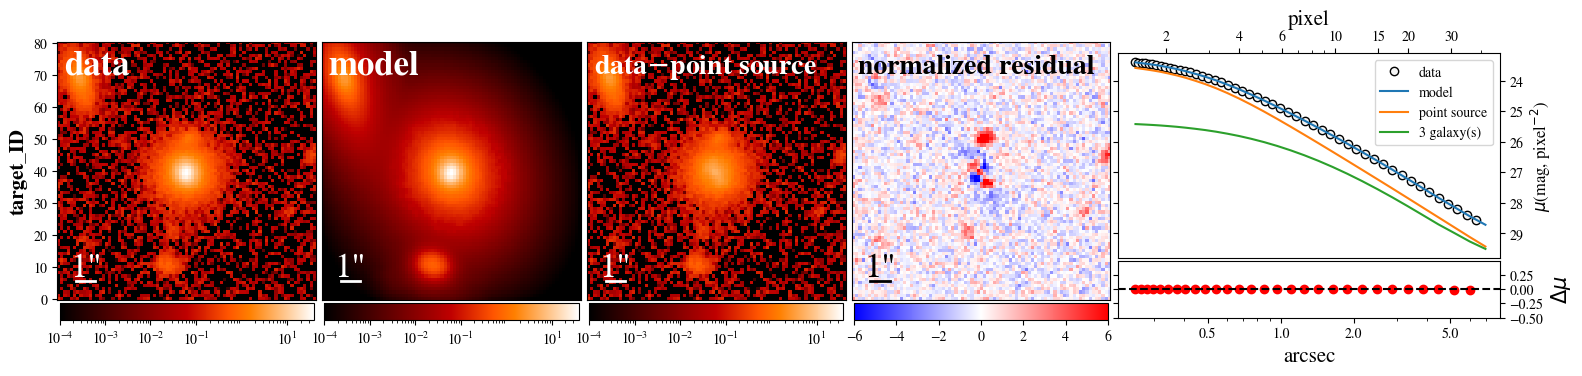

In [8]:
# Setting the fit_run again to fitting the sample:
fit_run = FittingProcess(fit_sepc, fitting_level=['shallow', 'deep'])
fit_run.run(algorithm_list = ['PSO','PSO'], setting_list=None,threadCount=2)
fit_run.plot_final_qso_fit()

### After image modeling, now you can remove the PS for measure the host Asymmetry.

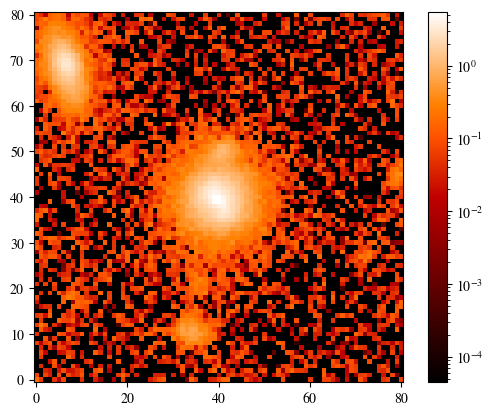

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 66.490863
         Iterations: 76
         Function evaluations: 153


Deblending: 100%|██████████████████████████████| 10/10 [00:00<00:00, 646.45it/s]


Plot the minimized abs residual:


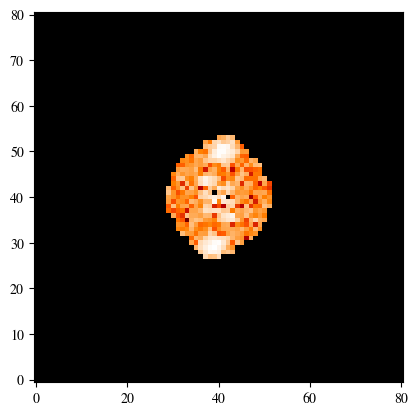

Plot the region to estiamte the background asymmetry:


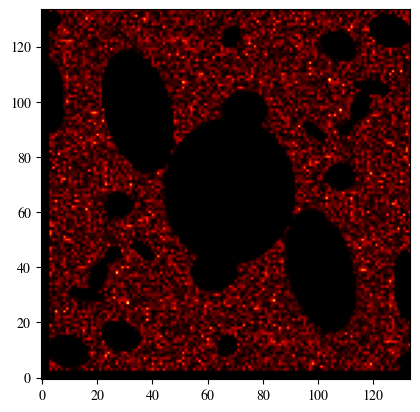

asymmetry : 0.08183207556538195


In [9]:
if_remeasure_bkg = True
asy_class = Measure_asy(fit_run, seg_cal_reg = 'or', obj_id=0, rm_ps = True)  #Here we set rm_ps = True
plt_fits(asy_class.img,colorbar=True)
asy_class.asy_segm(mask_type='segm') 
pos = asy_class.find_pos()

asy_class.make_bkg(rotate_pix = pos["x"], if_remeasure_bkg=if_remeasure_bkg)
asy = asy_class.cal_asymmetry(rotate_pix = pos["x"], if_plot=True, if_plot_bkg=True)
print('asymmetry :', asy)

## You can also measure the residual asymmetry:
### Note that , this flux value (for normalization) couldn't be obtained by the residual image anymore. So, one needs to input the object flux value for this calcualtion. 

Plot the data which is the residual image this time:


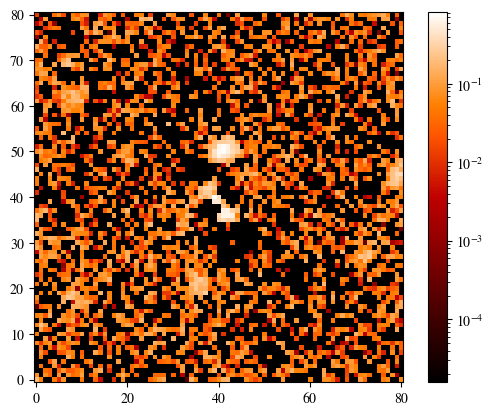

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 79.218681
         Iterations: 117
         Function evaluations: 228


Deblending: 100%|██████████████████████████████| 11/11 [00:00<00:00, 552.68it/s]


Plot the minimized abs residual:


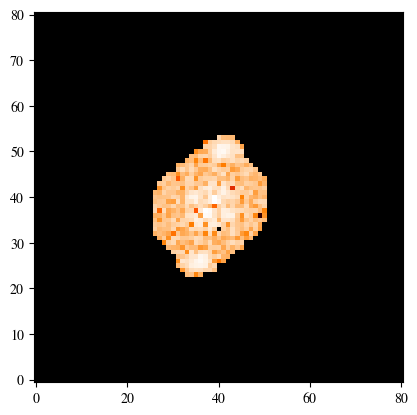

Plot the region to estiamte the background asymmetry:


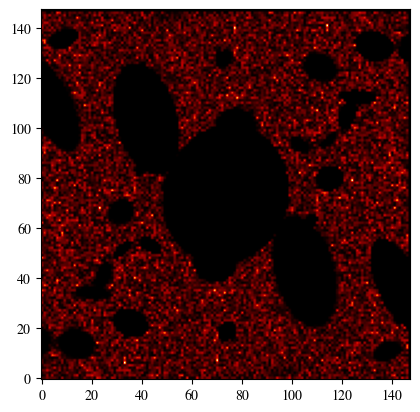

asymmetry : 0.09256219871149969


In [10]:
if_remeasure_bkg = True
#Here we set rm_model = True so that the residual image will be used.
asy_class = Measure_asy(fit_run, seg_cal_reg = 'or', obj_id=0, rm_model = True)  

print('Plot the data which is the residual image this time:')
plt_fits(asy_class.img,colorbar=True)
asy_class.asy_segm(mask_type='segm') 
pos = asy_class.find_pos()

asy_class.make_bkg(rotate_pix = pos["x"], if_remeasure_bkg=if_remeasure_bkg)

#Get the obj_flux value in that within the image calculated area; this is for the Asymmetry normalization.
data_rmPS = fit_run.fitting_specify_class.kwargs_data['image_data'] -  np.sum(fit_run.image_ps_list, axis = 0)
obj_flux = np.sum(data_rmPS[asy_class.cal_areas == True])

asy = asy_class.cal_asymmetry(rotate_pix = pos["x"], obj_flux = obj_flux, #Input the obj_flux in this function.
                              if_plot=True, if_plot_bkg=True)
print('asymmetry :', asy)

## Step 3 (For CAS):
### In the following three box, we show the measurement for the CAS for 1) the original image 2) data-ps (i.e., host) image and 3) residual image.

#### The returned cas values are:
* asymmetry
* smoothness (two values are returned based on absolute difference and positive difference)
* concentration
* Gini

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 86.502090
         Iterations: 81
         Function evaluations: 161
Plot the minimized abs residual:


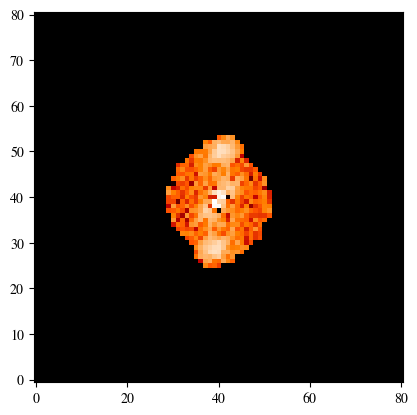

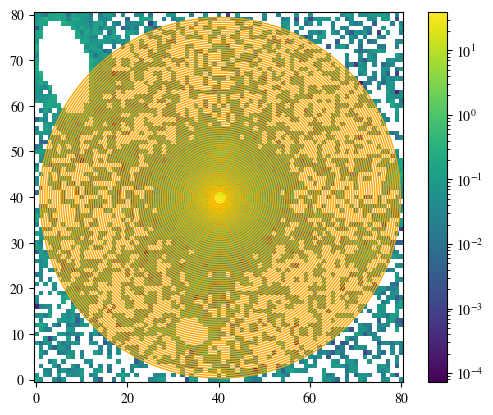

Plot the measure of petrosian radius:


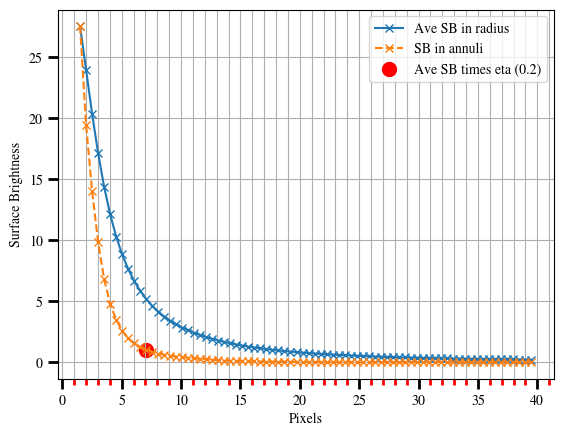

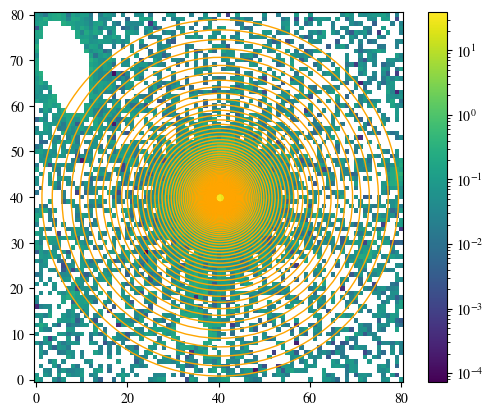

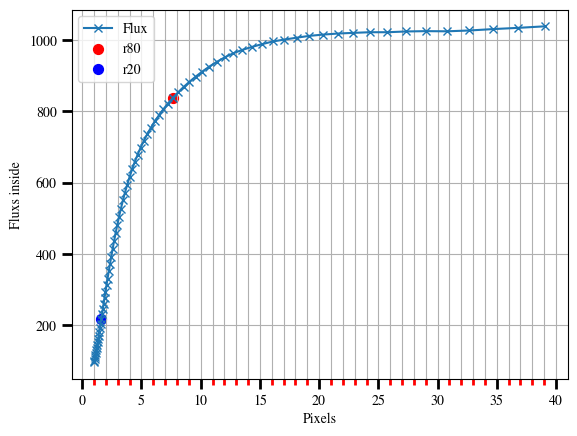

asymmetry: 0.04967623219195746
smoothness (by abs diff and pos diff): (0.04536498947713273, 0.03922873481624289)
concentration: 3.388214933740347
Gini: 0.6145211100072233


In [11]:
#For the original image:
from galight.tools.asymmetry_tools import CAS
CAS_class = CAS(fit_run, seg_cal_reg = 'or', obj_id=0, rm_ps=False)
cas = CAS_class.cal_CAS(mask_type='segm', extend=1, if_plot=True)
print('asymmetry:', cas[0])
print('smoothness (by abs diff and pos diff):', cas[1])
print('concentration:', cas[2])
print('Gini:', cas[3])

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 66.490863
         Iterations: 76
         Function evaluations: 153
Plot the minimized abs residual:


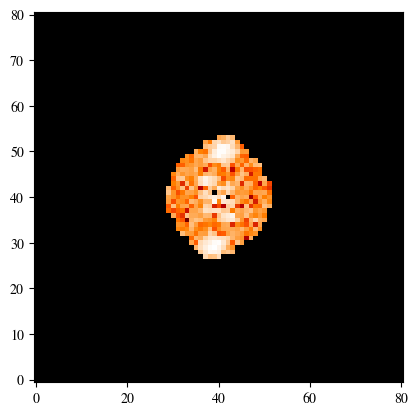

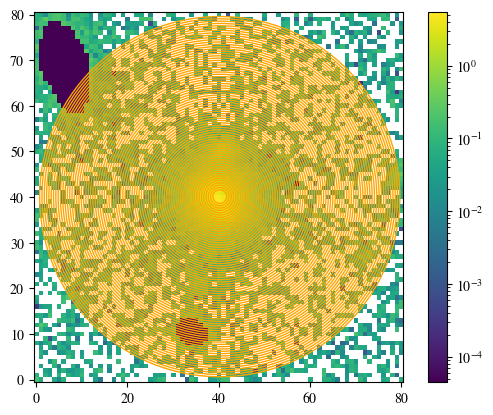

Plot the measure of petrosian radius:


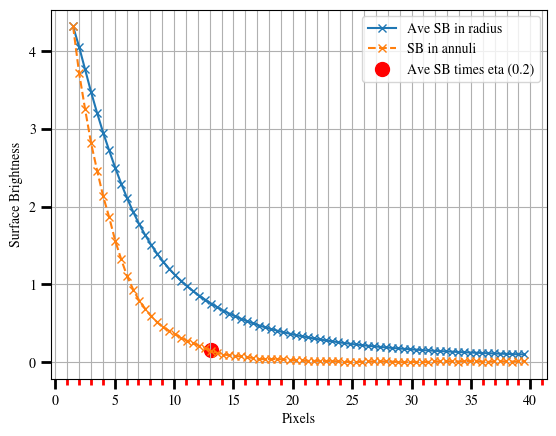

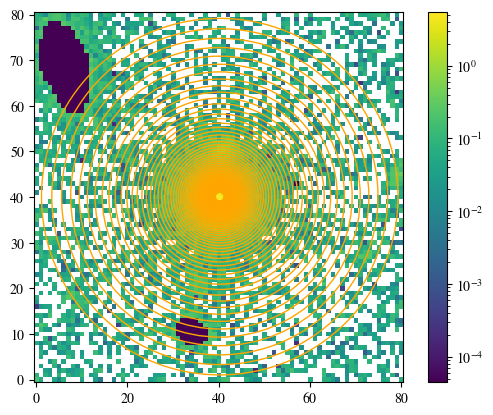

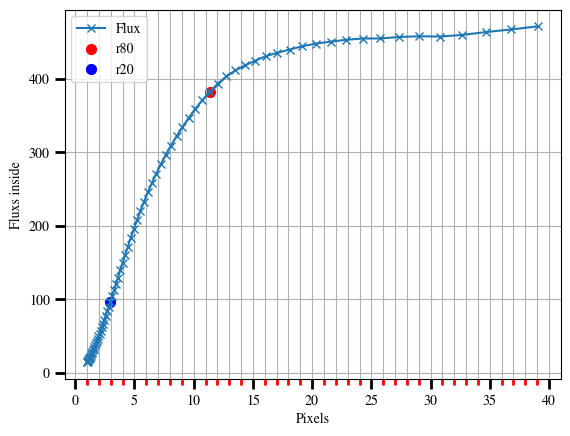

asymmetry: 0.0742721089776776
smoothness (by abs diff and pos diff): (0.11012698472947649, -0.01834277293022903)
concentration: 2.9217287579749467
Gini: 0.6654541050856175


In [12]:
#For the host image:
from galight.tools.asymmetry_tools import CAS
CAS_class = CAS(fit_run, seg_cal_reg = 'or', obj_id=0, rm_ps=True)
cas = CAS_class.cal_CAS(mask_type='segm',extend=1, if_plot=True)
print('asymmetry:', cas[0])
print('smoothness (by abs diff and pos diff):', cas[1])
print('concentration:', cas[2])
print('Gini:', cas[3])

In [13]:
#Calculate the smoothness for the residual image:
from galight.tools.asymmetry_tools import CAS
CAS_class = CAS(fit_run, obj_id=0, rm_model=True)  #Seeting rm_model = True for residual.
#Note that in the following equation, the image_org should be used to calculate the flux value with 0.25 and 1.25 of the petrosian radius.
cas = CAS_class.cal_CAS(mask_type='segm',extend=1, if_plot=False, if_residual=True, image_org = data_rmPS)
print('smoothness (for abs diff and pos diff):', cas[1])

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 79.218681
         Iterations: 117
         Function evaluations: 228
smoothness (for abs diff and pos diff): (0.07609927243900337, 0.03961584749571735)
